In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd, numpy as np
from pathlib import Path
import os, sys, yaml

# use notebook path to find repo root, path to repo parent directory, and airflow dags repo
# note that the two repos must by subdirs in some common parent for this to work
nb_dpath = Path(os.path.abspath(""))
repo_dpath = nb_dpath.parent
# append airflow-dags projs path and emp_retention repo path to python path
sys.path.append(str(repo_dpath))

# local imports
from datasets.load_dsets import load_walmart_dset

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

# walmart csv
- 143 weeks starting from Feb 2010 and ending on Oct 2012 (let's make the treatment period start on `'2012-09-07'` )
    - 8 weeks, 2 months (pretty long experiment)
- 45 stores
    - no missing weeks for any
- distribution notes
    - seems uniformly distributed at the moment, 
    - later, let's make a pareto distributed column (this way we can have some heterogenous splitting issues to play with)

### LOad the dset and add pareto sales column

In [4]:
# download and format
df = load_walmart_dset(pareto=True)


# print some stats
display(df.shape)
display(df.head(2))
display(df[['weekly_sales','pareto_sales']].describe())

(6435, 9)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,pareto_sales
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,142178.13
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,142478.49


,weekly_sales,pareto_sales
count,6.435000e+03,6.435000e+03
mean,1.046965e+06,9.672588e+05
std,5.643666e+05,1.277846e+06
min,2.099862e+05,2.634178e+04
25%,5.533501e+05,1.904581e+05
50%,9.607460e+05,4.161557e+05
75%,1.420159e+06,1.254509e+06
max,3.818686e+06,8.711469e+06


### Visualize the distributions and temporal for original dset and pareto dset

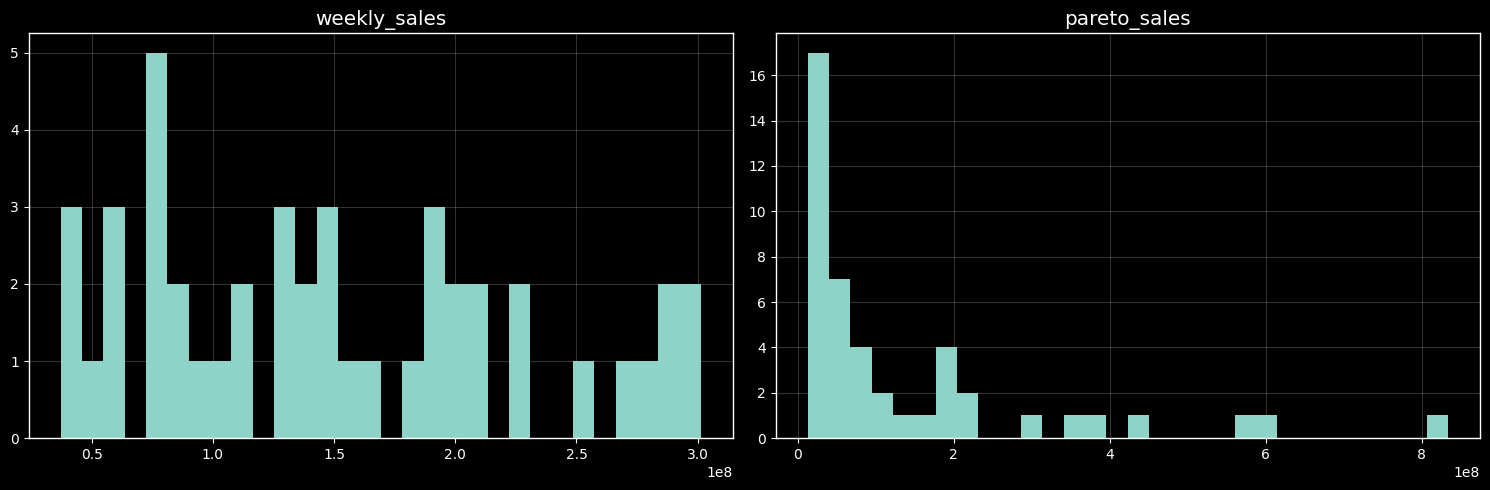

In [19]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

for ax, sales_col in zip(axes,['weekly_sales','pareto_sales']):
    df.groupby('store')[sales_col].sum().hist(bins=30, ax=ax)
    ax.set_title(sales_col); ax.grid(alpha=0.2)
plt.tight_layout()

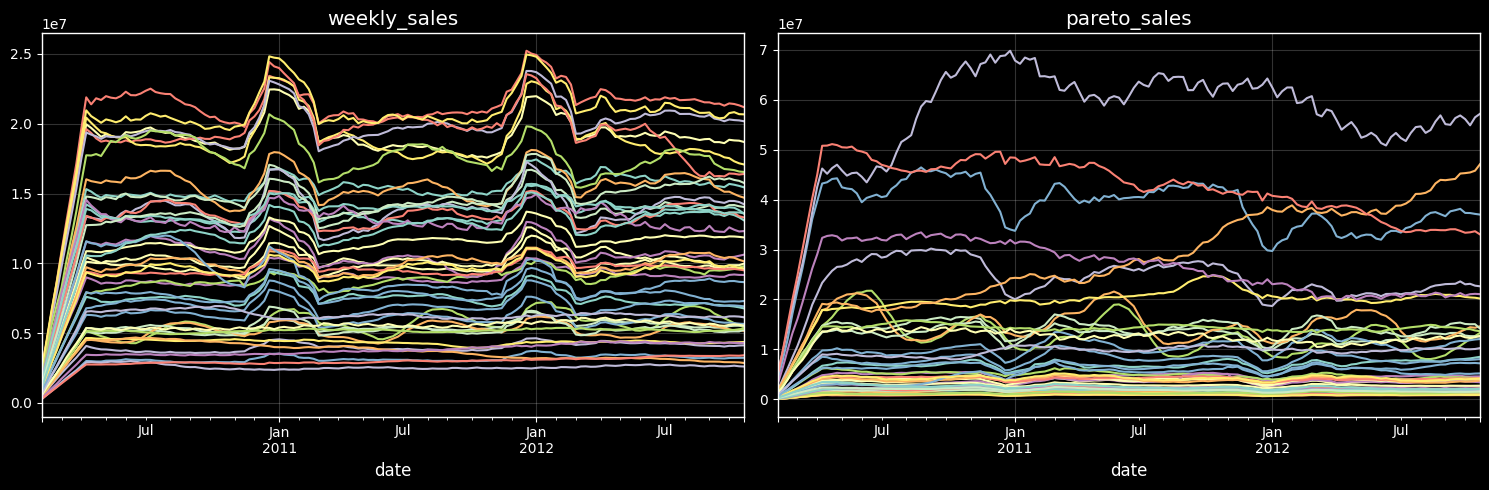

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
temp_df = df.set_index(['store','date'])

for ax, sales_col in zip(axes,['weekly_sales','pareto_sales']):
    for store in range(1,46):
        temp_df.loc[store, sales_col].rolling(10,1).sum().plot(ax=ax)
    ax.set_title(sales_col); ax.grid(alpha=0.2)
plt.tight_layout()



## Simple T test

### Rearrange for experimental data
Collapse the pre treatment (prior 8 weeks) down to one number (same for the post)

> NOte: we can choose to use the pareto column or the other

In [88]:
from walmart_utils import *

dset = SimpleExpData(df, 
                     sales_col='weekly_sales', 
                     intervention_day_str = "2012-09-07")
dset.designate_treatment_groups()
dset.add_effect(effect_params = (0.05, 0.02))
dset.exp_df.head()

,store,pre_sales,raw_post_sales,T,effect,adj_post_sales
0,1,20527671.52,12367968.81,1,0.064237,1.316245e+07
1,2,24755805.05,14870984.86,1,0.030604,1.532609e+07
2,3,5408856.34,3304331.82,0,0.000000,3.304332e+06
3,4,28211885.06,16979740.89,1,0.085605,1.843329e+07
4,5,4219680.98,2569200.64,0,0.000000,2.569201e+06


### Run a MC power analysis (on single set of parameters)
Here we can mess with 3 parameters: effect, percent treated, Type 1 error rate

In [89]:
mc_df, prop_reject = dset.run_t_test_mc(n_iters=1000, 
                                        effect_params = (0.05, 0.02), # mean, std for percent effect
                                        percent_treated=0.1,
                                        alpha=0.05)

print(f'power = {prop_reject}')
mc_df.head()

power = 0.091


,ttsat,pval
0,1.063437,0.358418
1,-0.130903,0.902235
2,0.347791,0.749109
3,0.362116,0.738043
4,-0.518954,0.631620


### Power Analysis on ttest for simple data
Again we can mess with 3 parameters: effect, percent treated, Type 1 error rate. Let's just look at 3 different percent treated values and a range of effect sizes

Takeaways
- (MBQ) percent treated isn't high enough at 10% (ie ~4-5 treated stores) -- see that our AA test isn't alpha
- similar for 30% treated but not as glaring (still only 12-15 treated stores)
- need to have somewhere between 25-30% lift to power 30% (!!!)
- 20% lift needed to power a 50% split

In [98]:
from walmart_utils import SimpleExpData

dset = SimpleExpData(df, 
                     sales_col='weekly_sales', 
                     intervention_day_str = "2012-09-07",
                     pre_treatment_start_day_str = "2012-06-08")

# params to investigate
percents = [0.1, 0.3, 0.5]
effect_sizes = np.linspace(0,0.4,9)
n_iters = 1000

outs = []
# run mc for all
for percent_treated in percents:
    # print(f'percent_treated: {percent_treated}')
    
    for effect_size in effect_sizes:
        # set std based on effect size
        effect_params = effect_size, effect_size * 0.02 # mean and std
        # run mc
        mc_df, prop_reject = dset.run_t_test_mc(n_iters=n_iters, 
                                                effect_params = effect_params,
                                                percent_treated=percent_treated,
                                                alpha=0.05)
        # print(f'effect_size: {round(effect_size,2)}--- power: {prop_reject}')
        # store results
        outs.append((percent_treated, effect_size, prop_reject))

results_df = pd.DataFrame(outs, columns=['percent_treated', 'effect_size', 'power'])

percent_treated: 0.1
effect_size: 0.0--- power: 0.091
effect_size: 0.05--- power: 0.093
effect_size: 0.1--- power: 0.081
effect_size: 0.15--- power: 0.056
effect_size: 0.2--- power: 0.077
effect_size: 0.25--- power: 0.088
effect_size: 0.3--- power: 0.088
effect_size: 0.35--- power: 0.106
effect_size: 0.4--- power: 0.111
percent_treated: 0.3
effect_size: 0.0--- power: 0.057
effect_size: 0.05--- power: 0.045
effect_size: 0.1--- power: 0.07
effect_size: 0.15--- power: 0.117
effect_size: 0.2--- power: 0.124
effect_size: 0.25--- power: 0.186
effect_size: 0.3--- power: 0.232
effect_size: 0.35--- power: 0.319
effect_size: 0.4--- power: 0.363
percent_treated: 0.5
effect_size: 0.0--- power: 0.069
effect_size: 0.05--- power: 0.069
effect_size: 0.1--- power: 0.095
effect_size: 0.15--- power: 0.135
effect_size: 0.2--- power: 0.2
effect_size: 0.25--- power: 0.255
effect_size: 0.3--- power: 0.346
effect_size: 0.35--- power: 0.44
effect_size: 0.4--- power: 0.517


### Power Analysis on ttest for pareto data
Takeaways
- (MBQ) percent treated isn't high enough at 10 and 30% (ie ~4-5 or 12-15 treated stores) -- see that our AA test isn't alpha
- even with 40% we don't get powered

In [99]:
from walmart_utils import SimpleExpData

dset = SimpleExpData(df, 
                     sales_col='pareto_sales', 
                     intervention_day_str = "2012-09-07",
                     pre_treatment_start_day_str = "2012-06-08")

# params to investigate
percents = [0.1, 0.3, 0.5]
effect_sizes = np.linspace(0,0.4,9)
n_iters = 1000

outs = []
# run mc for all
for percent_treated in percents:
    print(f'percent_treated: {percent_treated}')
    
    for effect_size in effect_sizes:
        # set std based on effect size
        effect_params = effect_size, effect_size * 0.02 # mean and std
        # run mc
        mc_df, prop_reject = dset.run_t_test_mc(n_iters=n_iters, 
                                                effect_params = effect_params,
                                                percent_treated=percent_treated,
                                                alpha=0.05)
        print(f'effect_size: {round(effect_size,2)}--- power: {prop_reject}')
        # store results
        outs.append((percent_treated, effect_size, prop_reject))

results_df = pd.DataFrame(outs, columns=['percent_treated', 'effect_size', 'power'])

percent_treated: 0.1
effect_size: 0.0--- power: 0.163
effect_size: 0.05--- power: 0.165
effect_size: 0.1--- power: 0.142
effect_size: 0.15--- power: 0.151
effect_size: 0.2--- power: 0.136
effect_size: 0.25--- power: 0.127
effect_size: 0.3--- power: 0.143
effect_size: 0.35--- power: 0.142
effect_size: 0.4--- power: 0.127
percent_treated: 0.3
effect_size: 0.0--- power: 0.077
effect_size: 0.05--- power: 0.052
effect_size: 0.1--- power: 0.047
effect_size: 0.15--- power: 0.046
effect_size: 0.2--- power: 0.047
effect_size: 0.25--- power: 0.05
effect_size: 0.3--- power: 0.045
effect_size: 0.35--- power: 0.045
effect_size: 0.4--- power: 0.056
percent_treated: 0.5
effect_size: 0.0--- power: 0.044
effect_size: 0.05--- power: 0.036
effect_size: 0.1--- power: 0.054
effect_size: 0.15--- power: 0.049
effect_size: 0.2--- power: 0.057
effect_size: 0.25--- power: 0.062
effect_size: 0.3--- power: 0.071
effect_size: 0.35--- power: 0.081
effect_size: 0.4--- power: 0.102


### Power Analysis for experimental design (ttest and simple data)
Again we can mess with 3 parameters: effect, percent treated, Type 1 error rate. Let's just look at 3 different percent treated values and a range of effect sizes

Takeaways
- (MBQ) percent treated isn't high enough at 10% (ie ~4-5 treated stores) -- see that our AA test isn't alpha
- similar for 30% treated but not as glaring (still only 12-15 treated stores)
- need to have somewhere between 25-30% lift to power 30% (!!!)
- 20% lift needed to power a 50% split

### Cuped on 

In [81]:
results_df

51

# keeping temporal element

> visualize with normal sales

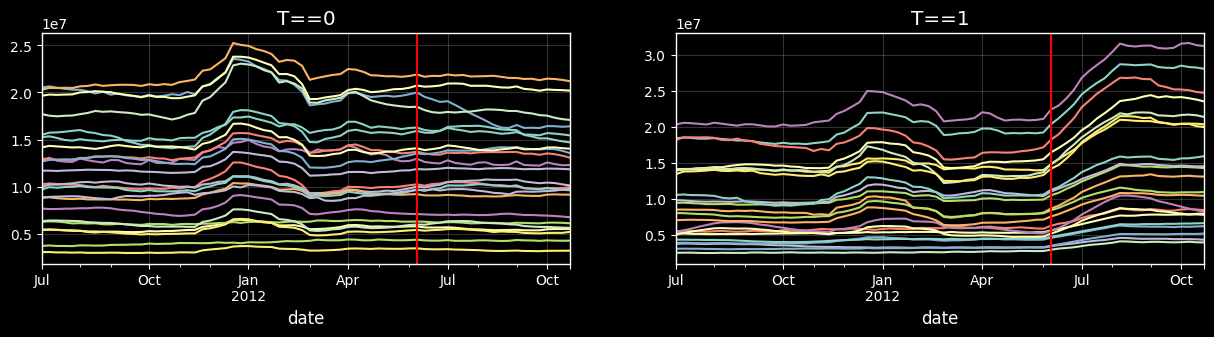

In [20]:
from walmart_utils import TreatedDF

sales_col='weekly_sales'

# make a big effect
run = TreatedDF(df, sales_col=sales_col, effect_params=(0.5, 0.02))
adj_sales_col = 'adj_sales' # same regardless of pareto or regular
fig, axes = plt.subplots(1,2,figsize=(15,3))

for ax, treated in zip(axes,[0,1]):
    temp_df = run.df.loc[run.df['T']==treated].set_index(['date']).sort_index()
    for store in temp_df.store.unique():
        temp_df.loc[temp_df.store==store, adj_sales_col].rolling(10,1).sum().iloc[-70:].plot(ax=ax)
    ax.grid(alpha=0.2); ax.set_title(f'T=={treated}');
    ax.axvline(run.intervention_date, c='r')

> visualize with pareto sales

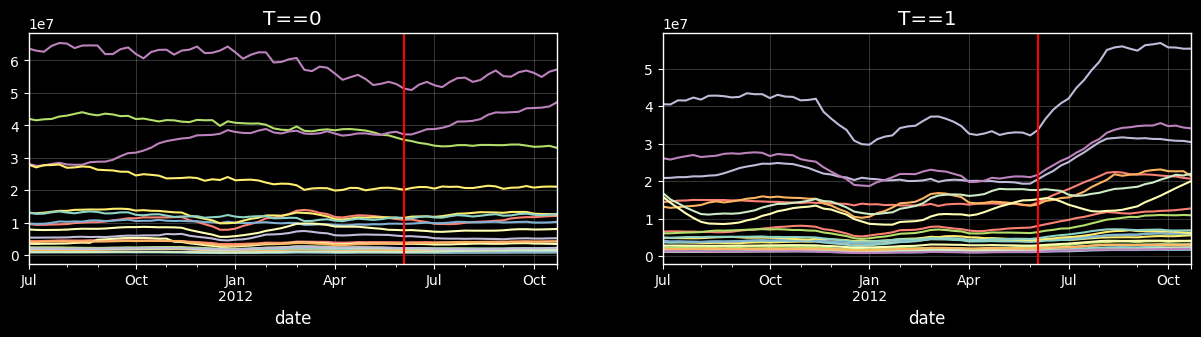

In [21]:
sales_col='pareto_sales'

# make a big effect
run = TreatedDF(df, sales_col=sales_col, effect_params=(0.5, 0.02))
adj_sales_col = 'adj_sales' # same regardless of pareto or regular
fig, axes = plt.subplots(1,2,figsize=(15,3))

for ax, treated in zip(axes,[0,1]):
    temp_df = run.df.loc[run.df['T']==treated].set_index(['date']).sort_index()
    for store in temp_df.store.unique():
        temp_df.loc[temp_df.store==store, adj_sales_col].rolling(10,1).sum().iloc[-70:].plot(ax=ax)
    ax.grid(alpha=0.2); ax.set_title(f'T=={treated}');
    ax.axvline(run.intervention_date, c='r')

### Run an MC simulation for power analysis

> see that with such a small sample it's nearly impossible to power with just a typical t test (even with huge effect sizes)
- not to mention, we didn't even AA test the stat properties to start with so we may have non-exchangeability issues already
- continue with chatgpt code here https://chatgpt.com/c/68a233b4-f928-832c-9b9a-59232c36395c

In [85]:
from walmart_utils import MCSimulation

powers = []
effect_sizes = np.linspace(0,0.4,9)

for effect_size in effect_sizes:
    simul = MCSimulation(df, effect_params = (effect_size, effect_size * 0.02), pre_or_post='post')
    out_df = simul.run_many_simulations(n_sim=1000)
    power = sum(out_df.pval <= 0.05) / out_df.shape[0]
    print(effect_size,power)
    powers.append(power)

0.0 0.049
0.05 0.051
0.1 0.093
0.15000000000000002 0.128
0.2 0.189
0.25 0.272
0.30000000000000004 0.339
0.35000000000000003 0.424
0.4 0.549


> Using pre data, may not make the most sense because actually in reality it will all be pre we just choose some of it to be "treated" for our simulation

In [77]:
from walmart_utils import MCSimulation

simul = MCSimulation(df, effect_params = (0.5, 0.02), pre_or_post='pre')
# simul.generate_single_run_results()
out_df = simul.run_many_simulations(n_sim=1000)

sum(out_df.pval <= 0.05) / out_df.shape[0]

0.05

> visually inspect

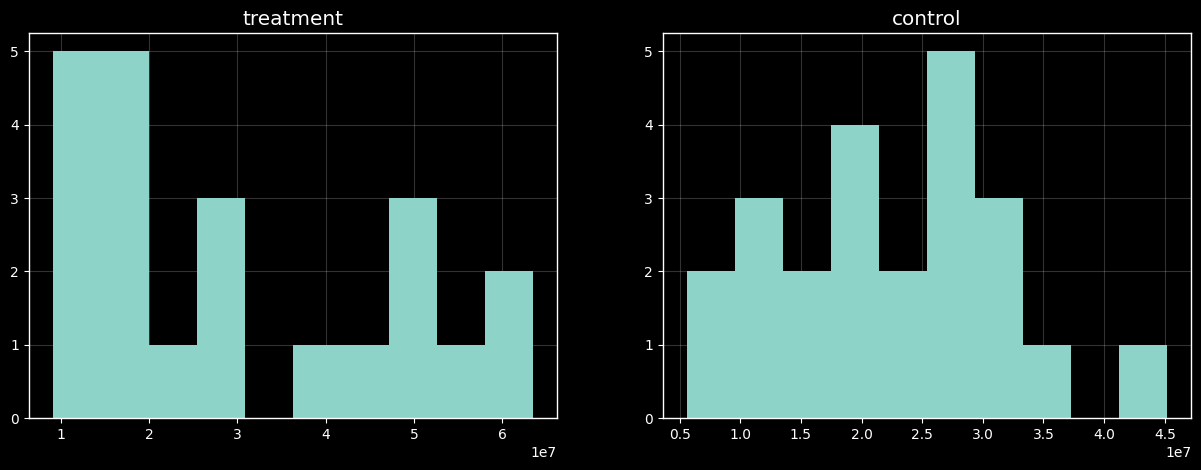

In [218]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

for ax, ser, name in zip(axes,[treated, control],['treatment','control']):
    ser.hist(ax=ax); ax.grid(alpha=0.2), ax.set_title(name)